In [1]:
import math
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# import cv2
plt.rcParams['image.cmap'] = 'gray'

### import functions from scripts

In [2]:
import os
os.chdir('saliency_model/')

In [3]:
from utils import *
from itti_koch_features import *

## Load the images

In [4]:
img = mpimg.imread('../imgs/balloons.png')
# img2 = cv2.imread('../imgs/balloons.png')

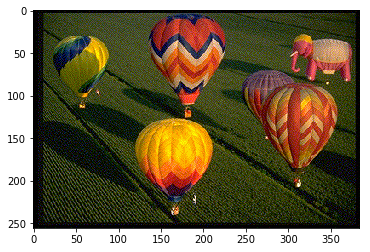

In [5]:
plt.imshow(img);

convert to double if image is uint8

In [6]:
# TODO 

---

## Determine the size and the number of center scales:  
First we scale the image to different sizes, so it has different resolutions we can work with.

In [7]:
mapwidth = 64
mapheight = round(img.shape[0] * (mapwidth / img.shape[1]))
scalars = [1, 2, 3]

img_list = downsample_image(img, mapheight, mapwidth, scalars)

In [22]:
mapsize = [ round(np.size(img,0) / np.size(img,1) * mapwidth), mapwidth ];
mapsize
# chanmap = chanmap + wj * imresize(maps{ci}{cj}, mapSize ); #TODO: weighted scale

[43, 64]

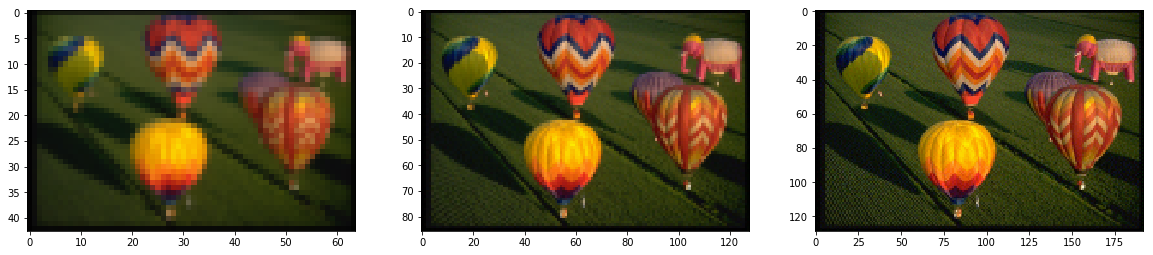

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img_list[0])
ax[1].imshow(img_list[1])
ax[2].imshow(img_list[2]);

---

## split to channels & compute salience in each

### Channel 1: Compute intensity

In [9]:
#from skimage.morphology import disk
#from skimage.filters.rank import mean

In [10]:
# img_avg = mean(img_hat, disk(5));
# comment: until now, img_hat was just the R-dimension of the RGB image

Compute intensity of the image as average over the RGB values:

In [11]:
img_int = compute_intensity(img_list)

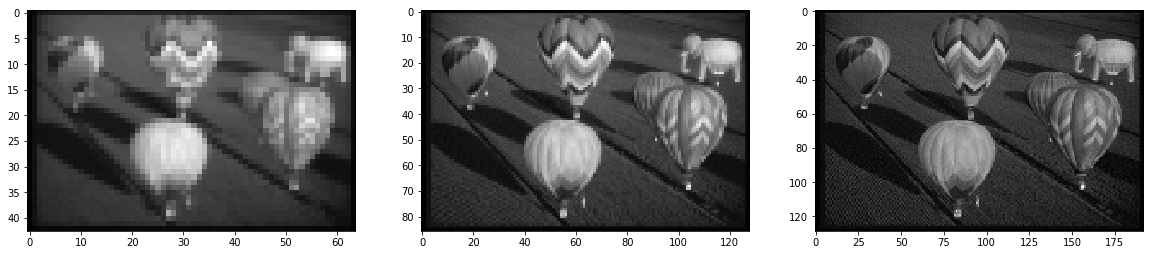

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img_int[0])
ax[1].imshow(img_int[1])
ax[2].imshow(img_int[2]);

## Compute saliency map: apply center-surround to feature map
### has to be done for each feature map

Convolve the feature maps with the center surround function / Mexican Hat to get the saliency maps.

In [13]:
# convolve with mexican hat function (receptive Field)
sigma1 = 2
sigma2 = 3
rf = receptive_field_matrix(lambda x, y: mexican_hat(x, y, sigma1, sigma2))
# TODO replace img by the saliency maps

img_hat = []
for i in img_int:
    img_hat.append(signal.convolve(i, rf, mode='same'))

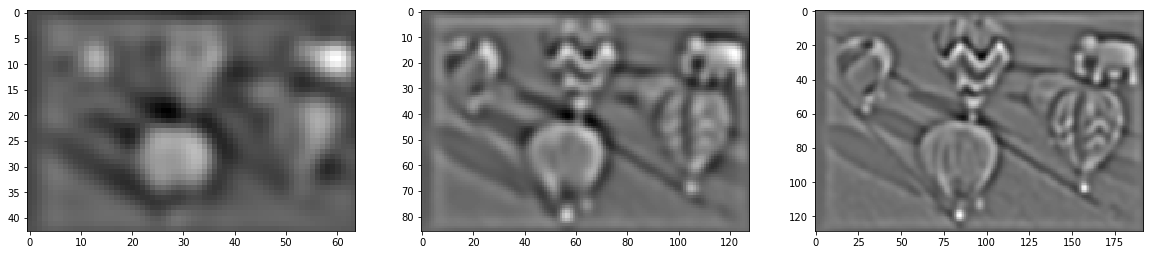

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img_hat[0])
ax[1].imshow(img_hat[1])
ax[2].imshow(img_hat[2]);

Now, what is done in the original MATLAB code is the following:   
(1) create 1-dim Gausskernel and convolve it with the image twice (in two dimensions) - I think this should be the same as what we directly do in two dimensions? They also only use a Gaussian kernel and not a real receptive field...  
(2) after convolution, get the saliency map by subtracting the convoluted image from the original intensities and squaring the difference

**>> Why??**

In [15]:
# implement step (2):
sal_map = []
for i in range(len(img_int)):
    sal_map.append((img_int[i] - img_hat[i])**2)

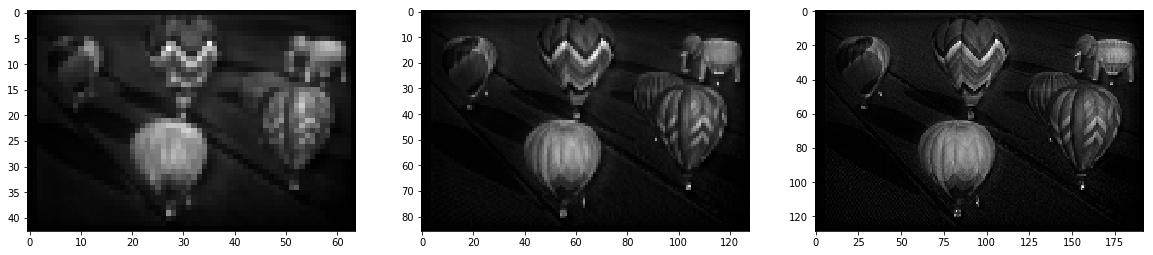

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(sal_map[0])
ax[1].imshow(sal_map[1])
ax[2].imshow(sal_map[2]);

## next steps:
(1) construct several mexican hat functions with different sigmas, create a weighted sum of the created saliency maps (weight according to their "peakiness", as done in MATLAB?) and normalize  
(2) if the channel has different features (like RGB in colors), create also a weighted sum of those saliency maps  
(3) combine the saliency maps for the different channels (i.e. intensity, color, orientation and color bias) to one saliency map by a weighted sum  
(3a) top-down modulation here?

In [31]:
sal_map_resize = []
sal_intensity = np.zeros(mapsize)

for ii in sal_map:
    temp = resize(ii, mapsize, mode='constant')
    sal_map_resize.append(temp)
    sal_intensity = sal_intensity + temp

/home/ateska/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


''

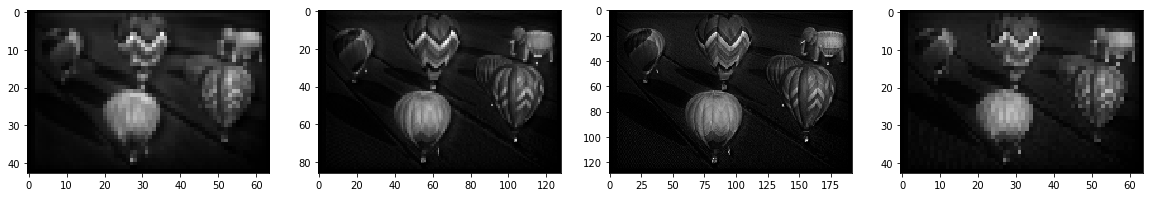

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
ax[0].imshow(sal_map[0])
ax[1].imshow(sal_map[1])
ax[2].imshow(sal_map[2])
ax[3].imshow(sal_intensity)
;

-----

## Orientation filter

In [17]:
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from skimage.transform import resize
from scipy import ndimage as nd

### Generate multiple Gabor filters

In [74]:
kernels = []

phase = [0, 90]  # should be used in offset
sigma = 4
frequency = 0.15

theta = 4 # decides how many different angles of the filter we will have 


# for ph in phase:
for theta in range(int(theta)):
    theta = theta / 4. * np.pi
    kernel = np.real(gabor_kernel(frequency, theta=theta,
                                  sigma_x=sigma, sigma_y=sigma,
                                  offset=0))
    kernels.append(kernel)

### Vizualize all the filters

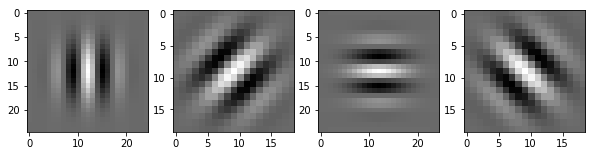

In [75]:
j = len(kernels)

fig, ax = plt.subplots(1, j, figsize=(10, 10))
for i in range(j):
    ax[i].imshow(kernels[i])

In [76]:
def compute_feats(image, kernels):
    '''compute features for multiple kernels: convolve with image'''
    feats = np.zeros_like(image)
    
    for kernel in kernels:
        filtered = nd.convolve(image, kernel)
        feats = feats + filtered

#     feats = feats / len(kernels)  # normalize
    
    return feats 

### We start by working on img_hat == squeez(mean(img,3))

In [77]:
img_orient = []

for i in range(len(img_hat)):
    img_orient.append(compute_feats(img_hat[i], kernels))

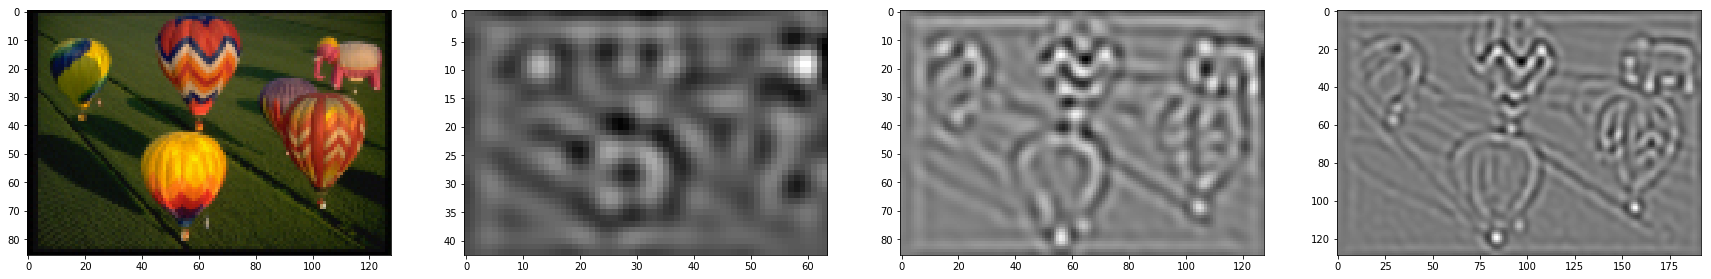

In [78]:
fig, ax = plt.subplots(1, 4, figsize=(30, 30))
ax[0].imshow(img_list[1])
ax[1].imshow(img_orient[0]);
ax[2].imshow(img_orient[1]);
ax[3].imshow(img_orient[2]);

### Calculate saliency maps

In [79]:
sal_map_orient = []
for i in range(len(img_int)):
    sal_map_orient.append((img_orient[i] - img_hat[i])**2)

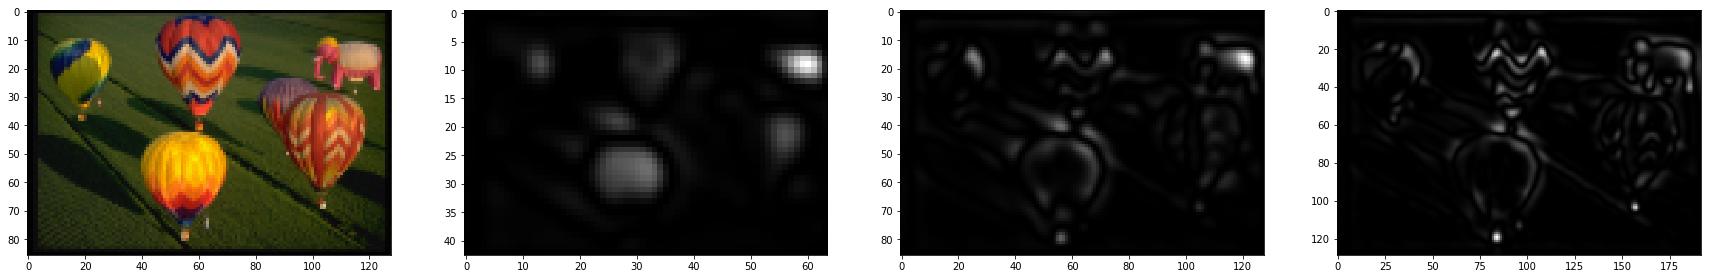

In [80]:
fig, ax = plt.subplots(1, 4, figsize=(30, 30))
ax[0].imshow(img_list[1])
ax[1].imshow(sal_map_orient[0]);
ax[2].imshow(sal_map_orient[1]);
ax[3].imshow(sal_map_orient[2]);

### Resize the output to the same size of mapsize

In [81]:
sal_orient_resize = []
sal_orient = np.zeros(mapsize)

for ii in sal_map_orient:
    temp_orient = resize(ii, mapsize, mode='constant')
    sal_orient_resize.append(temp_orient)
    sal_orient = sal_orient + temp_orient

/home/ateska/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


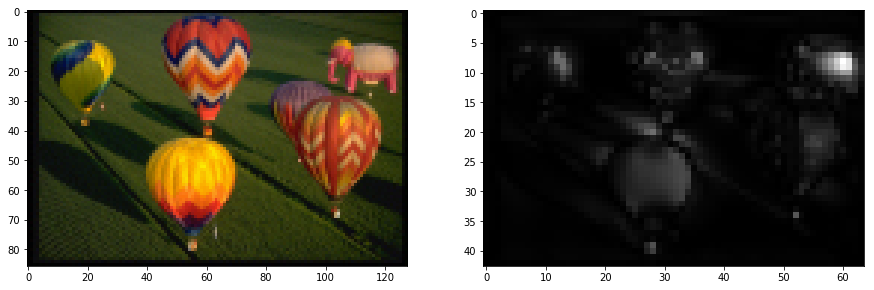

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(img_list[1])
ax[1].imshow(sal_orient);

### This following part is missing and I don't fully get it yet

In [21]:
# f0 = myconv2(img(:,:,fr),param.gabor{angi}.g0);
# f90 = myconv2(img(:,:,fr),param.gabor{angi}.g90);
# map(:,:,fr) = attenuateBorders( abs(f0) + abs(f90) , 13 );

# filter.g0 = gaborFilter(angle,0);
# filter.g90 = gaborFilter(angle,90);